This NB demonstrates the xcube **SMOS L2C data store** "smos".

In [1]:
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

# Utilities for notebook visualization
import shapely.geometry
import IPython.display
from IPython.display import JSON
import matplotlib.pyplot as plt

In [2]:
import dask.distributed
dask.distributed.Client(processes=True, n_workers=8)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 15.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59183,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.85 GiB
Comm: tcp://127.0.0.1:59236,Total threads: 2
Dashboard: http://127.0.0.1:59237/status,Memory: 1.98 GiB
Nanny: tcp://127.0.0.1:59186,


In [3]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

In [4]:
get_data_store_params_schema('smos')

In [5]:
store = new_data_store('smos')

In [6]:
store.get_open_data_params_schema()

In [7]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

In [8]:
store.get_data_opener_ids()

('dataset:zarr:smos', 'mldataset:zarr:smos')

In [9]:
mlds = store.open_data("SMOS-L2C-SM", opener_id="mldataset:zarr:smos", time_range=("2023-05-01", "2023-05-02"))

creating new DGG instance!


In [10]:
mlds.num_levels

6

In [11]:
ds = mlds.get_dataset(5)
ds

opening L2 product for time_idx=0


<xarray.Dataset>
Dimensions:            (time: 13, lat: 126, lon: 256, bnds: 2)
Coordinates:
  * lat                (lat) float64 87.89 86.48 85.08 ... -85.08 -86.48 -87.89
  * lon                (lon) float64 -179.3 -177.9 -176.5 ... 176.5 177.9 179.3
  * time               (time) datetime64[ns] 2023-05-01T01:54:46.500000 ... 2...
    time_bnds          (time, bnds) datetime64[ns] dask.array<chunksize=(13, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    Chi_2              (time, lat, lon) float32 dask.array<chunksize=(1, 126, 256), meta=np.ndarray>
    Chi_2_P            (time, lat, lon) float32 dask.array<chunksize=(1, 126, 256), meta=np.ndarray>
    N_RFI_X            (time, lat, lon) float32 dask.array<chunksize=(1, 126, 256), meta=np.ndarray>
    N_RFI_Y            (time, lat, lon) float32 dask.array<chunksize=(1, 126, 256), meta=np.ndarray>
    RFI_Prob           (time, lat, lon) float32 dask.array<chunksize=(1, 126, 256), meta=np.ndarray>
    Soil_Moisture      (time, lat, lon) float32 dask.array<chunksize=(1, 126, 256), meta=np.ndarray>
    Soil_Moisture_DQX  (time, lat, lon) float32 dask.array<chunksize=(1, 126, 256), meta=np.ndarray>

In [12]:
ds.time

<xarray.DataArray 'time' (time: 13)>
array(['2023-05-01T01:54:46.500000000', '2023-05-01T03:34:51.500000000',
       '2023-05-01T05:14:55.500000000', '2023-05-01T06:55:00.500000000',
       '2023-05-01T07:44:59.000000000', '2023-05-01T08:35:05.000000000',
       '2023-05-01T10:15:09.000000000', '2023-05-01T11:55:13.000000000',
       '2023-05-01T14:25:18.000000000', '2023-05-01T16:55:27.000000000',
       '2023-05-01T18:35:32.000000000', '2023-05-01T20:15:36.000000000',
       '2023-05-01T21:55:40.500000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-05-01T01:54:46.500000 ... 2023-05-01T...
Attributes:
    long_name:      time
    standard_name:  time
    bounds:         time_bnds

In [13]:
ds.time_bnds

<xarray.DataArray 'time_bnds' (time: 13, bnds: 2)>
dask.array<open_dataset-15d78a9446c4972dc038f0c492b8313atime_bnds, shape=(13, 2), dtype=datetime64[ns], chunksize=(13, 2), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2023-05-01T01:54:46.500000 ... 2023-05-0...
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(13, 2), meta=np.ndarray>
Dimensions without coordinates: bnds

In [14]:
ds.Soil_Moisture

<xarray.DataArray 'Soil_Moisture' (time: 13, lat: 126, lon: 256)>
dask.array<open_dataset-15d78a9446c4972dc038f0c492b8313aSoil_Moisture, shape=(13, 126, 256), dtype=float32, chunksize=(1, 126, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 87.89 86.48 85.08 83.67 ... -85.08 -86.48 -87.89
  * lon      (lon) float64 -179.3 -177.9 -176.5 -175.1 ... 176.5 177.9 179.3
  * time     (time) datetime64[ns] 2023-05-01T01:54:46.500000 ... 2023-05-01T...
Attributes:
    units:    m3 m-3

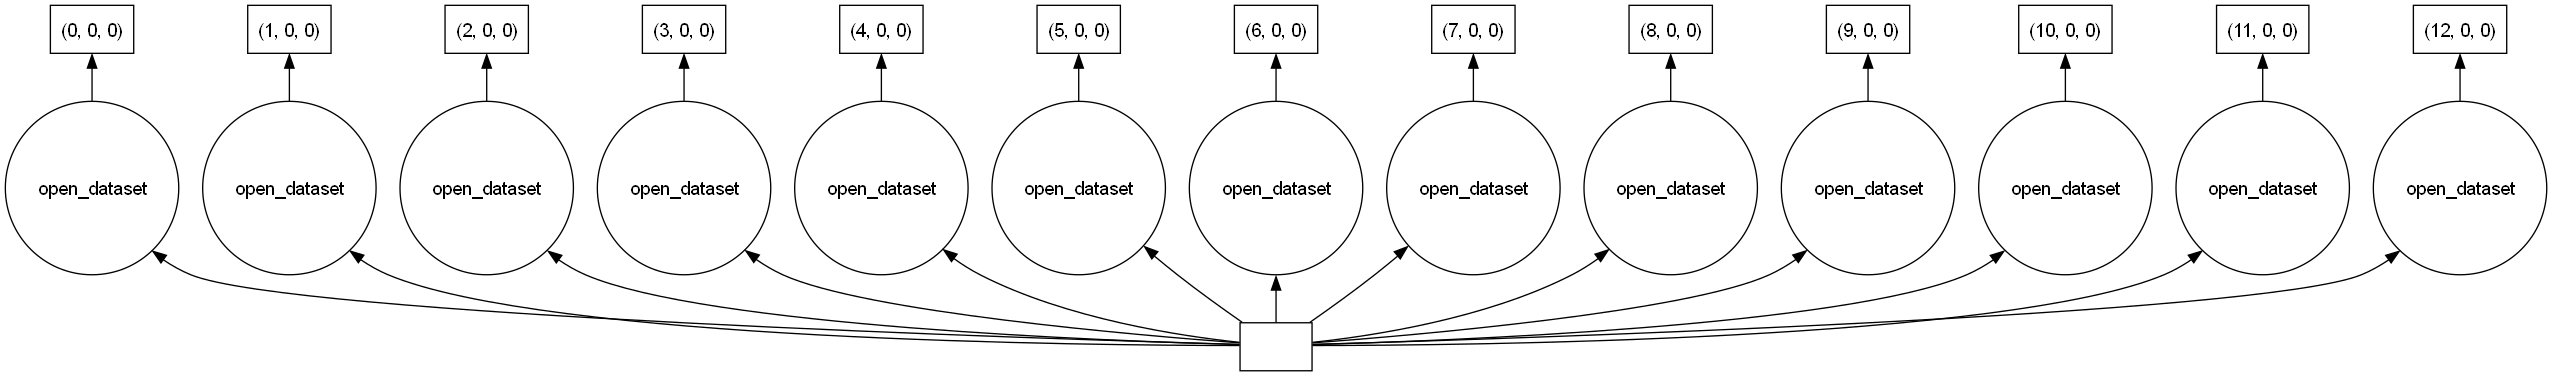

In [15]:
ds.Soil_Moisture.data.visualize()

TimeStepLoader.__getstate__() called!
TimeStepLoader.__setstate__() called!
creating new DGG instance!
TimeStepLoader.__getstate__() called!


opening L2 product for time_idx=0
creating global L2 product for level=5
mapped L2 var 'Soil_Moisture'


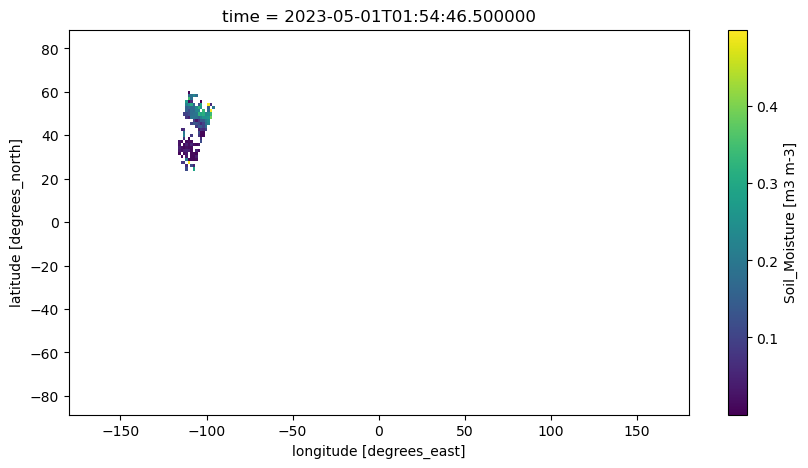

In [16]:
ds.Soil_Moisture.isel(time=0).plot.imshow(figsize=(10, 5))

TimeStepLoader.__getstate__() called!
TimeStepLoader.__setstate__() called!
creating new DGG instance!
TimeStepLoader.__getstate__() called!


opening L2 product for time_idx=1
creating global L2 product for level=5
mapped L2 var 'Soil_Moisture'


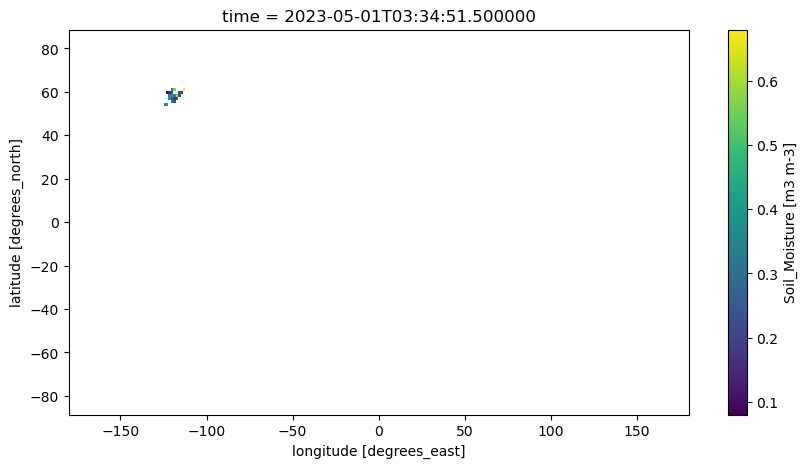

In [17]:
ds.Soil_Moisture.isel(time=1).plot.imshow(figsize=(10, 5))

TimeStepLoader.__getstate__() called!
TimeStepLoader.__setstate__() called!
creating new DGG instance!
TimeStepLoader.__getstate__() called!


opening L2 product for time_idx=6
creating global L2 product for level=5
mapped L2 var 'Soil_Moisture'


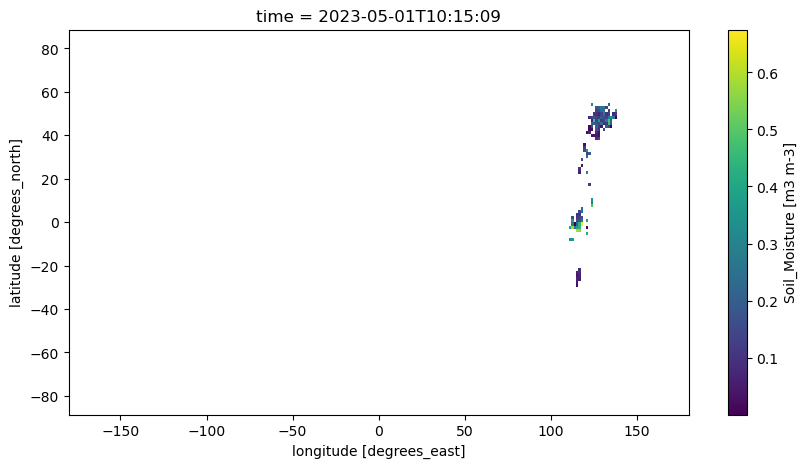

In [18]:
ds.Soil_Moisture.isel(time=6).plot.imshow(figsize=(10, 5))

In [19]:
# %%timeit -n 1 -r 1
result = ds.Soil_Moisture.mean("time").compute()

TimeStepLoader.__getstate__() called!
TimeStepLoader.__setstate__() called!
creating new DGG instance!
TimeStepLoader.__getstate__() called!


opening L2 product for time_idx=4
opening L2 product for time_idx=8
opening L2 product for time_idx=5
opening L2 product for time_idx=9
opening L2 product for time_idx=10
opening L2 product for time_idx=1
opening L2 product for time_idx=0
creating global L2 product for level=5
mapped L2 var 'Soil_Moisture'
creating global L2 product for level=5
opening L2 product for time_idx=11
creating global L2 product for level=5
mapped L2 var 'Soil_Moisture'
creating global L2 product for level=5
opening L2 product for time_idx=2
opening L2 product for time_idx=12
mapped L2 var 'Soil_Moisture'
mapped L2 var 'Soil_Moisture'
creating global L2 product for level=5
opening L2 product for time_idx=3
creating global L2 product for level=5
creating global L2 product for level=5
opening L2 product for time_idx=6
opening L2 product for time_idx=7
mapped L2 var 'Soil_Moisture'
creating global L2 product for level=5
mapped L2 var 'Soil_Moisture'
creating global L2 product for level=5
mapped L2 var 'Soil_Mois

RuntimeError: Requested dask.distributed scheduler but no Client active.

In [ ]:
result.plot.imshow(figsize=(10, 5))

In [ ]:
#for name, var in ds.variables.items():
#    display(name, var.encoding)

In [ ]:
ds_rechunked = ds.chunk(dict(time=1, lat=4032 // 4, lon=8192 // 8))
#ds_rechunked = ds_rechunked.drop('time_bnds')
for v in ds_rechunked.variables.values():
    del v.encoding["chunks"]
    del v.encoding["preferred_chunks"]

In [ ]:
#ds_rechunked.to_zarr("smos.zarr", mode="w")